In [24]:
from pathlib import Path
# import nfp
import numpy as np
import pandas as pd
import tarfile
from pymatgen.core import Structure
import json
import gzip
import re
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

## Data Exploration

### Check prototype structures
Double check that the prototype structures don't have atoms in the same positions

In [3]:
def get_structures(filename, ids=None):
    with gzip.open(Path(structure_dir, filename), 'r') as f:
        data = json.loads(f.read().decode())
        
        if ids is None:
            ids = data.keys()
            
        for key in tqdm(ids):
            if key in data:
                yield {'id': key, 'structure': Structure.from_dict(data[key])}        

In [4]:
from nfp.preprocessing.crystal_preprocessor import PymatgenPreprocessor
from pymatgen.core import Structure
preprocessor = PymatgenPreprocessor()

def preprocess_structure(structure):
    scaled_struct = structure.copy()
    inputs = preprocessor(scaled_struct, train=True)

    # scale structures to a minimum of 1A interatomic distance
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        raise RuntimeError(f"Error with {structure}")

    inputs["distance"] /= inputs["distance"].min()
    return inputs

2022-03-11 17:04:37.723932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-03-11 17:04:37.723965: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
structure_dir = Path('/projects/rlmolecule/jlaw/inputs/structures/')
calc_energy = pd.read_csv(Path(structure_dir, 'battery_relaxed_energies.csv'))

In [6]:
protos_file = "/home/jlaw/projects/arpa-e/crystals/rlmolecule/rlmolecule/crystal/inputs/icsd_prototypes.json.gz"
proto_strcs = pd.DataFrame(get_structures(protos_file))
proto_strcs.columns = ['rlcrystal_id', 'structure']
proto_strcs.head(2)

  0%|          | 0/4170 [00:00<?, ?it/s]

,rlcrystal_id,structure
0,_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512,"[[12.70681846 1.413475 0.1000818 ] H, [4.0..."
1,_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945,"[[ 6.13025 9.783375 17.3280125] K, [ 6.130..."


In [7]:
proto_strcs['id'] = proto_strcs['rlcrystal_id'].apply(lambda x: 'icsd_' + x.split('_')[-1])
proto_strcs = proto_strcs.set_index('id')
proto_strcs.head(2)

,rlcrystal_id,structure
id,,
icsd_174512,_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512,"[[12.70681846 1.413475 0.1000818 ] H, [4.0..."
icsd_079945,_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945,"[[ 6.13025 9.783375 17.3280125] K, [ 6.130..."


In [8]:
def is_valid(structure):
    scaled_struct = structure.copy()
    inputs = preprocessor(structure, train=True)

    # check the minimum interatomic distance
    # if it's 0, then one or more atoms occupy the same site
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        return False
    return True

In [22]:
def split_comp_to_eles_and_type(comp: str):
    """
    Extract the elements and composition type from a given composition
    e.g., _1_1_4 from Li1Sc1F4
    """
    # this splits by the digits
    # e.g., for "Li1Sc1F4": ['Li', '1', 'Sc', '1', 'F', '4', '']
    split = np.asarray(re.split('(\d+)', comp))
    elements = tuple(sorted(split[range(0, len(split) - 1, 2)]))
    stoich = split[range(1, len(split), 2)]
    # sort the stoichiometry to get the correct order of the comp type
    comp_type = '_' + '_'.join(map(str, sorted(map(int, stoich))))
    return elements, comp_type

In [26]:
def get_stoich_from_comp(comp: str):
    # split by the digits
    # e.g., for "Li1Sc1F4": ['Li', '1', 'Sc', '1', 'F', '4', '']
    split = np.asarray(re.split('(\d+)', comp))
    stoich = tuple(map(int, split[range(1, len(split), 2)]))
    return stoich

In [112]:
proto_strcs['valid_proto'] = proto_strcs['structure'].progress_apply(is_valid)

2022-03-11 10:17:33.669531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-03-11 10:17:33.671545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-03-11 10:17:33.672708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-03-11 10:17:33.674057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared 

In [132]:
print(f"{len(proto_strcs[proto_strcs['valid_proto'] == True])} / {len(proto_strcs)} valid prototype structures")

4144 / 4170 valid prototype structures


In [99]:
icsd_strcs = pd.DataFrame(get_structures("icsd_structures.json.gz"))

  0%|          | 0/16445 [00:00<?, ?it/s]

In [9]:
battery_structures_volrelaxed = pd.DataFrame(get_structures('volrelax/battery_relaxed_vol_structures.json.gz')).set_index('id')
battery_structures_volunrelaxed = pd.DataFrame(get_structures('volrelax/battery_unrelaxed_vol_structures.json.gz')).set_index('id')
battery_structures_relaxed = pd.DataFrame(get_structures('battery_relaxed_structures.json.gz')).set_index('id')
battery_structures_unrelaxed = pd.DataFrame(get_structures('battery_unrelaxed_structures.json.gz')).set_index('id')

  0%|          | 0/30324 [00:00<?, ?it/s]

  0%|          | 0/30522 [00:00<?, ?it/s]

  0%|          | 0/67840 [00:00<?, ?it/s]

  0%|          | 0/67840 [00:00<?, ?it/s]

In [32]:
battery_structures_volrelaxed['comp'] = battery_structures_volrelaxed.index.map(lambda x: x.split('_')[0])
battery_structures_volrelaxed['comp_type'] = battery_structures_volrelaxed.comp.apply(lambda x: split_comp_to_eles_and_type(x)[1])
battery_structures_volrelaxed['stoich'] = battery_structures_volrelaxed.comp_type.apply(lambda x: x.replace('_', ''))
battery_structures_volrelaxed.head(2)

,structure,comp,comp_type,stoich
id,,,,
Zn1La3I2P3_sg189_icsd_076297_1,"[[1.55036141 2.68529936 0. ] La, [4.580...",Zn1La3I2P3,_1_2_3_3,1233
Zn1La3I2P3_sg14_icsd_260350_1,"[[2.63923841 7.5685779 0.38571714] La, [6.263...",Zn1La3I2P3,_1_2_3_3,1233


In [136]:
# check how many have a valid prototype structure
battery_structures_volrelaxed['proto_id'] = battery_structures_volrelaxed.index.map(lambda x: 'icsd_' + x.split('_')[-2])
df_volrel = battery_structures_volrelaxed.merge(proto_strcs['valid_proto'], left_on='proto_id', right_index=True, how='inner')
df_volrel.head(2)

,structure,proto_id,valid_proto
id,,,
Zn1La3I2P3_sg189_icsd_076297_1,"[[1.55036141 2.68529936 0. ] La, [4.580...",icsd_076297,True
Zn1La3I2P3_sg189_icsd_076297_2,"[[1.60535746 2.78056045 0. ] P, [4.7425...",icsd_076297,True


In [137]:
df_volrel['valid_proto'].sum()

30241

In [139]:
df_volrel['valid_strc'] = df_volrel['structure'].progress_apply(is_valid)

  0%|          | 0/30324 [00:00<?, ?it/s]

In [146]:
print(f"{len(df_volrel[df_volrel['valid_strc'] == True])} / {len(df_volrel)} are valid")

30245 / 30324 are valid


In [148]:
df_volrel[df_volrel['valid_strc'] == False]['proto_id'].value_counts()

icsd_158336    16
icsd_107859    15
icsd_038443    12
icsd_065634    12
icsd_246867    10
icsd_607870    10
icsd_044995     4
Name: proto_id, dtype: int64

In [147]:
df_volrel.loc['Mg3F2O2_sg15_icsd_158336_2']

structure      [[-0.033255  3.541605  0.      ] O, [0. 0. 0.]...
proto_id                                             icsd_158336
valid_proto                                                False
valid_strc                                                 False
Name: Mg3F2O2_sg15_icsd_158336_2, dtype: object

### Check how many volume-relaxed structures have a matching relaxed battery structure


In [18]:
volrelaxed = battery_structures_volrelaxed
relaxed = battery_structures_relaxed
print(f"{len(volrelaxed[volrelaxed.index.isin(relaxed.index)])} "
      f"/ {len(volrelaxed)} volume-relaxed structures have a corresponding relaxed structure")

20335 / 30324 volume-relaxed structures have a corresponding battery relaxed structure


In [20]:
# see if there is an unrelaxed file
unrelaxed_orig_dir = "/projects/rlmolecule/shubham/file_transfer/decorations/relaxed/battery_hypotheticals/unrelaxed_original"
volunrelax_strcs = set()
for strc_id in volrelaxed.index:
    unrelax_file = Path(unrelaxed_orig_dir, f"POSCAR_{strc_id}")
    if unrelax_file.is_file():
        volunrelax_strcs.add(strc_id)
print(f"{len(volunrelax_strcs)} volume-relaxed structures "
      "have a corresponding original unrelaxed file")

20335 volume-relaxed structures have a corresponding original unrelaxed file


In [ ]:
# get the unrelaxed structures
unrelaxed_orig_dir = "/projects/rlmolecule/shubham/file_transfer/decorations/structures/"
unrelaxed_structures = {}
for strc_id, row in tqdm(volrelaxed.iterrows(), total=len(volrelaxed)):
    # print(row)
    unrelax_file = Path(unrelaxed_orig_dir, row['comp_type'], row['comp'], f"POSCAR_{strc_id}")
    if unrelax_file.is_file():
        strc = Structure.from_file(unrelax_file).as_dict()
        unrelaxed_structures[strc_id] = strc
print(f"Loaded {len(volunrelax_strcs)} unrelaxed structures")

  0%|          | 0/30324 [00:00<?, ?it/s]

Loaded 30324 unrelaxed structures


In [38]:
# see if there is an unrelaxed file in a different folder
unrelaxed_orig_dir = "/projects/rlmolecule/pstjohn/crystal_inputs/dls_scaled_inputs"
volunrelax_strcs2 = set()
for strc_id, row in tqdm(volrelaxed.iterrows()):
    # print(row)
    unrelax_file = Path(unrelaxed_orig_dir, row['comp_type'], row['comp'], f"POSCAR_{strc_id}")
    if unrelax_file.is_file():
        volunrelax_strcs2.add(strc_id)
print(f"{len(volunrelax_strcs2)} volume-relaxed structures "
      "have a corresponding original unrelaxed file")

0it [00:00, ?it/s]

7488 volume-relaxed structures have a corresponding original unrelaxed file


In [44]:
def write_structures_file(structures_file, structures_dict, round_float=None):
    """ Write pymatgen structures to a gzipped json file
    *round_float*: round floats in json file to the specified number
    """

    def round_floats(o):
        if isinstance(o, float): return round(o, round_float)
        if isinstance(o, dict): return {k: round_floats(v) for k, v in o.items()}
        if isinstance(o, (list, tuple)): return [round_floats(x) for x in o]
        return o

    if round_float is not None:
        structures_dict = round_floats(structures_dict)

    print(f"writing {structures_file}")
    with gzip.open(structures_file, 'w') as out:
        out.write(json.dumps(structures_dict).encode())

In [45]:
out_dir = "/projects/rlmolecule/jlaw/inputs/structures/volrelax"
unrel_file = f"{out_dir}/battery_unrelaxed_vol_structures.json.gz"
write_structures_file(unrel_file, unrelaxed_structures, round_float=5)

writing /projects/rlmolecule/jlaw/inputs/structures/volrelax/battery_unrelaxed_vol_structures.json.gz


In [ ]:
battery_structures_volunrelaxed['proto_id'] = battery_structures_volunrelaxed.index.map(lambda x: 'icsd_' + x.split('_')[-2])
df_volunrel = battery_structures_volunrelaxed.merge(proto_strcs['valid_proto'], left_on='proto_id', right_index=True, how='inner')

In [46]:
# load the energies
df = pd.read_csv("/projects/rlmolecule/jlaw/inputs/structures/volrelax/battery_volrelaxed_energies.csv")
print(len(df))
df.head(2)

26006


,comp_type,composition,id,energyperatom
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092


<AxesSubplot:>

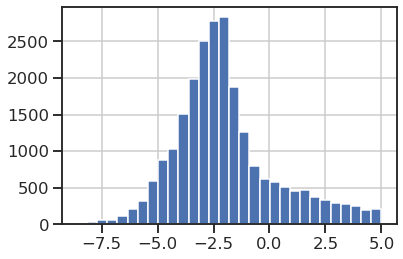

In [48]:
# limit to -10 to 10 eV/atom 
df2 = df[(df['energyperatom'] > -10) & (df['energyperatom'] < 5)]
df2['energyperatom'].hist(bins=30)

In [49]:
print(len(df2), len(df))

23398 24864


<AxesSubplot:>

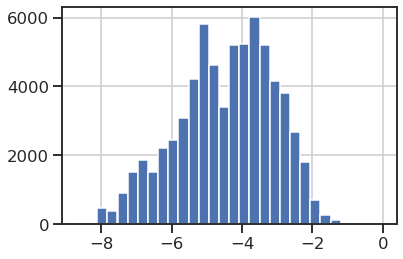

In [159]:
# compare distribution to DFT relaxed structures
calc_energy.energyperatom.hist(bins=30)

In [87]:
len(df)

24863

In [10]:
# double check the energies of the structures that were used in training
# the above "min_distance == 0" filter was applied to this all_data.p file
from pathlib import Path
inputs_dir = Path("../outputs/20220309_volrelax")
data = pd.read_pickle(Path(inputs_dir, "all_data.p"))

In [85]:
data.head(2)

,comp_type,composition,id,energyperatom,inputs
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176,"{'site': [7, 7, 7, 7, 4, 4, 4, 4, 10, 10, 10, ..."
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092,"{'site': [4, 4, 7, 7, 10, 10, 10, 10, 10, 10, ..."


In [94]:
print(f"{len(data)} / {len(df_volrel)} structures have DFT energy and pass min-dist filter")

25769 / 30324 structures pass the min distance filter


<AxesSubplot:>

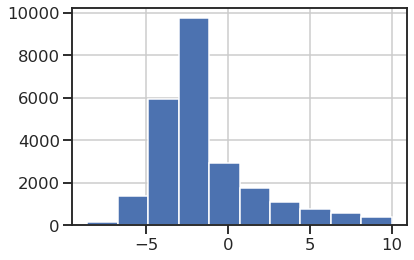

In [88]:
data = data[(data['energyperatom'] > -10) & (data['energyperatom'] < 10)]
data['energyperatom'].hist()

In [89]:
len(data)

24674

### Check if the structures that gave a distance warning were also outliers

In [58]:
strc_dir = "/projects/rlmolecule/jlaw/inputs/structures/volrelax"
flagged = pd.read_csv(Path(strc_dir, "distance_warning_strcs.txt"), squeeze=True, header=None)
print(len(flagged))

8014


In [56]:
outliers = df[(df.energyperatom < -10) | (df.energyperatom > 5)]
outliers

,comp_type,composition,id,energyperatom
11,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg18_icsd_081313_1,8.297
28,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg62_icsd_040828_1,9.626
64,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg58_icsd_262122_2,6.802
68,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg58_icsd_262122_1,5.630
81,_1_1_2_5,Na1Ti1Sb2P5,Na1Ti1Sb2P5_sg2_icsd_068184_1,9.476
...,...,...,...,...
25916,_1_1_1_2_3,K1W1Al1O3S2,K1W1Al1O3S2_sg14_icsd_180844_1,7.335
25950,_1_1_1_2_3,Zn1Y1Si1F3P2,Zn1Y1Si1F3P2_sg62_icsd_180845_6,7.041
25983,_1_1_1_2_3,Zn1Y1Si1F3P2,Zn1Y1Si1F3P2_sg14_icsd_180844_6,6.306
25987,_1_1_1_2_3,Zn1Y1Si1F3P2,Zn1Y1Si1F3P2_sg14_icsd_180844_4,5.767


In [59]:
len(outliers[outliers.id.isin(flagged)])

1404

<AxesSubplot:>

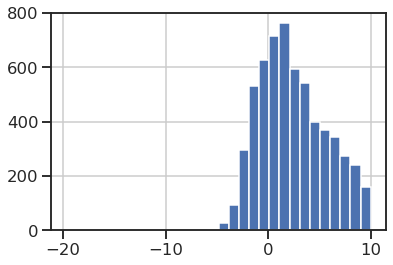

In [60]:
df[df.id.isin(flagged)].energyperatom.hist(bins=30)